In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
data = yf.download('AAPL','2008-01-01','2023-03-29')
recent_data = yf.download('AAPL','2023-03-29')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
recent_data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-29,159.369995,161.050003,159.350006,160.770004,160.770004,51305700
2023-03-30,161.529999,162.470001,161.270004,162.360001,162.360001,49501700
2023-03-31,162.440002,165.000000,161.910004,164.899994,164.899994,68694700


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,7.116786,7.152143,6.876786,6.958571,5.922566,1079178800
2008-01-03,6.978929,7.049643,6.881786,6.961786,5.925303,842066400
2008-01-04,6.837500,6.892857,6.388929,6.430357,5.472995,1455832000
2008-01-07,6.473214,6.557143,6.079643,6.344286,5.399736,2072193200
2008-01-08,6.433571,6.516429,6.100000,6.116071,5.205502,1523816000


In [5]:
data.shape

(3836, 6)

In [6]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,7.116786,7.152143,6.876786,6.958571,5.922566,1079178800
2008-01-03,6.978929,7.049643,6.881786,6.961786,5.925303,842066400
2008-01-04,6.837500,6.892857,6.388929,6.430357,5.472995,1455832000
2008-01-07,6.473214,6.557143,6.079643,6.344286,5.399736,2072193200
2008-01-08,6.433571,6.516429,6.100000,6.116071,5.205502,1523816000
2008-01-09,6.117857,6.410714,6.010714,6.407143,5.453238,1813882000
2008-01-10,6.342143,6.464286,6.264643,6.357857,5.411291,1482975200
2008-01-11,6.285714,6.351786,6.071429,6.167500,5.249274,1232285600
2008-01-14,6.340000,6.407857,6.256071,6.385000,5.434391,1100450400


In [7]:
data.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-15,151.190002,153.250000,149.919998,152.990005,152.990005,77167900
2023-03-16,152.160004,156.460007,151.639999,155.850006,155.850006,76161100
2023-03-17,156.080002,156.740005,154.279999,155.000000,155.000000,98862500
2023-03-20,155.070007,157.820007,154.149994,157.399994,157.399994,73641400
2023-03-21,157.320007,159.399994,156.539993,159.279999,159.279999,73938300
2023-03-22,159.300003,162.139999,157.809998,157.830002,157.830002,75701800
2023-03-23,158.830002,161.550003,157.679993,158.929993,158.929993,67622100
2023-03-24,158.860001,160.339996,157.850006,160.250000,160.250000,59196500
2023-03-27,159.940002,160.770004,157.869995,158.279999,158.279999,52390300


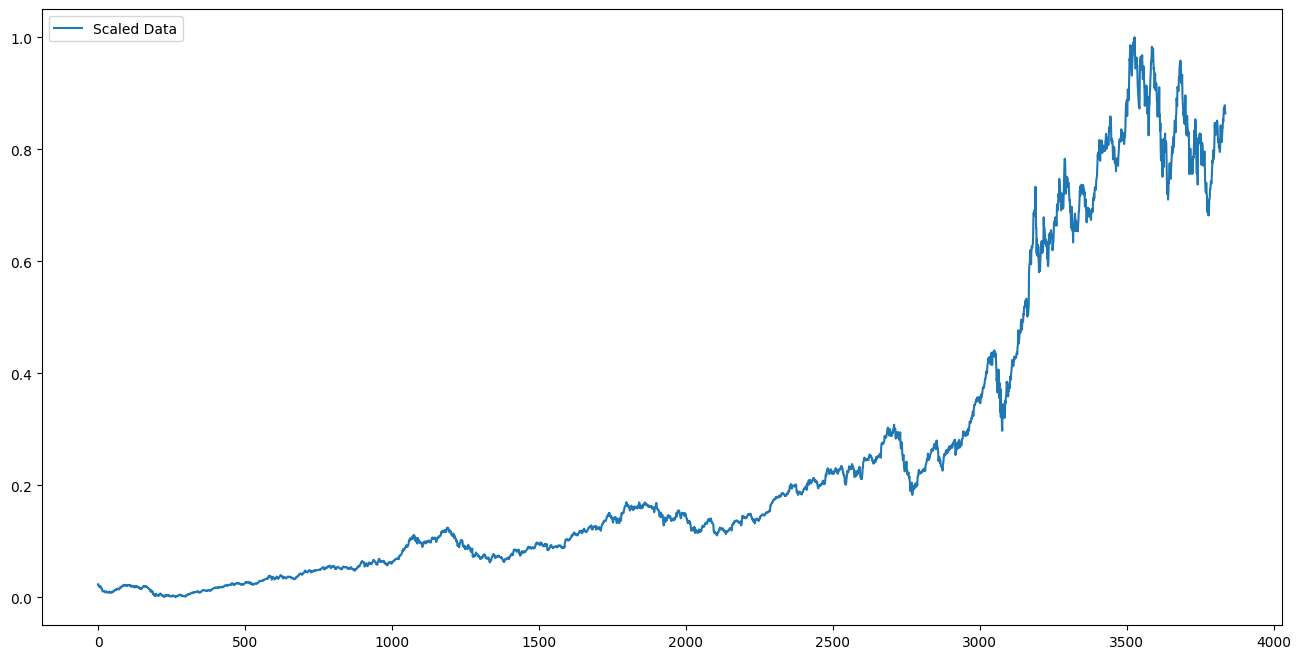

In [9]:
#Scale the data and plot the scaled data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

#plot the scaled data from day 0 to current day
plt.figure(figsize=(16,8))
plt.plot(scaled_data, label='Scaled Data')
plt.legend(loc='upper left')
plt.show()

In [10]:
print(scaled_data)

[[0.02324395]
 [0.02326189]
 [0.02029661]
 ...
 [0.87858307]
 [0.86759081]
 [0.8640755 ]]


In [11]:
close_values = scaler.inverse_transform(scaled_data)
print(close_values)

[[  6.95857096]
 [  6.96178579]
 [  6.43035698]
 ...
 [160.25      ]
 [158.27999878]
 [157.6499939 ]]


In [12]:
#Create a new dataframe with only the 'Close' column
data = data.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on (80% of the data)
training_size = int(np.ceil( len(scaled_data) * .8 ))
test_size = int(np.ceil( len(scaled_data) * .2 ))

#2860 is 80 percent of the total number of rows in the dataset
print("Total Rows in Training Dataset: ", training_size)
print("Total Rows in Testing Dataset: ", test_size)

Total Rows in Training Dataset:  3069
Total Rows in Testing Dataset:  768


In [13]:
#Split the data in to training and testing data, 80% training and 20% testing starting from the beginning of the dataset
train_data = scaled_data[0:training_size , :] #From 0 to 3061
test_data = scaled_data[training_size:len(scaled_data), :] #From 3061 to the end

#remove null values
train_data = train_data[~np.isnan(train_data).any(axis=1)]
test_data = test_data[~np.isnan(test_data).any(axis=1)]

#print the shape of the training and testing data
print("Training Data Shape: ", train_data.shape)
print("Testing Data Shape: ", test_data.shape)

Training Data Shape:  (3069, 1)
Testing Data Shape:  (767, 1)


In [14]:
#Time step is the number of days we want to look back to predict the next closing price
#We need use the training data to create the x_train and y_train data sets where x_train is the closing price of the previous 14 years and y_train is the closing price of the next day
#if data is 120, 130, 125, 140, 134, and 150 then x_train would be 120, 130, 125, 140, 134 and y_train would be 150
#We will do the same for the test data and then check the accuracy of the model

#Function to create the x_train and y_train data sets
def create_dataset (dataset, time_step=1):
    dataX, dataY = [], []
    #Loop through the data and create the x_train and y_train data sets
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] #Start from 0 to time_step and add to a
        dataX.append(a) #Store the values from 0 to time_step in dataX
        dataY.append(dataset[i+time_step, 0]) #Store the value of the next day in dataY
    return np.array(dataX), np.array(dataY) #Return the training data and the testing data as numpy arrays

In [15]:
#time step is the number of days we want to look back to predict the next closing price and we will use 30 days for this model (Hyperparamater Tuning) 
time_step = 30

#Create the training data set
x_train, y_train = create_dataset(train_data, time_step)

#180 features and 2550 rows
print (x_train.shape) #the training data should have 30 features for 30 days
print (y_train.shape)

(3038, 30)
(3038,)


In [16]:
#Create the testing data set
x_test, y_test = create_dataset(test_data, time_step)

#180 features an 730 rows
print(x_test.shape)
print(y_test.shape)

(736, 30)
(736,)


In [17]:
#Reshape the data to fit the LSTM model
#The LSTM model expects the data to be in the form of [samples, time steps, features] and right now our data is in the form [samples, features]
#The last two parameters are fed to the LSTM model as input
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [18]:
#Create a LSTM model with 1 layer of 256 neurons and 30 days look back
model = Sequential()
#Add the first LSTM layer
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

#One final output layer to predict the closing price
model.add(Dense(1))

#Compile the model with the adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [20]:
#Fit the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
48/48 [==============================] - 25s 305ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 2/50
48/48 [==============================] - 12s 257ms/step - loss: 1.8616e-04 - val_loss: 0.0013
Epoch 3/50
48/48 [==============================] - 11s 223ms/step - loss: 1.9654e-04 - val_loss: 0.0015
Epoch 4/50
48/48 [==============================] - 7s 142ms/step - loss: 1.8375e-04 - val_loss: 9.5548e-04
Epoch 5/50
48/48 [==============================] - 5s 110ms/step - loss: 1.6065e-04 - val_loss: 9.0179e-04
Epoch 6/50
48/48 [==============================] - 7s 148ms/step - loss: 1.3991e-04 - val_loss: 0.0012
Epoch 7/50
48/48 [==============================] - 6s 115ms/step - loss: 1.5892e-04 - val_loss: 0.0011
Epoch 8/50
48/48 [==============================] - 7s 148ms/step - loss: 1.4983e-04 - val_loss: 0.0021
Epoch 9/50
48/48 [==============================] - 5s 109ms/step - loss: 1.4391e-04 - val_loss: 8.4371e-04
Epoch 10/50
48/48 [==============================] - 

In [21]:
#Get the training data predictions and convert to the original scale
train_predict = model.predict(x_train)
train_predict = scaler.inverse_transform(train_predict)

95/95 [==============================] - 3s 23ms/step


In [22]:
#Get the testing data predictions and convert to the original scale
test_predict = model.predict(x_test)
test_predict = scaler.inverse_transform(test_predict)

23/23 [==============================] - 1s 25ms/step


In [23]:
#Get performance metrics for the model on the training and testing data using root mean squared error (RMSE)
trainScore = math.sqrt(mean_squared_error(y_train, train_predict))
testScore = math.sqrt(mean_squared_error(y_test, test_predict))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 30.42 RMSE
Test Score: 137.50 RMSE


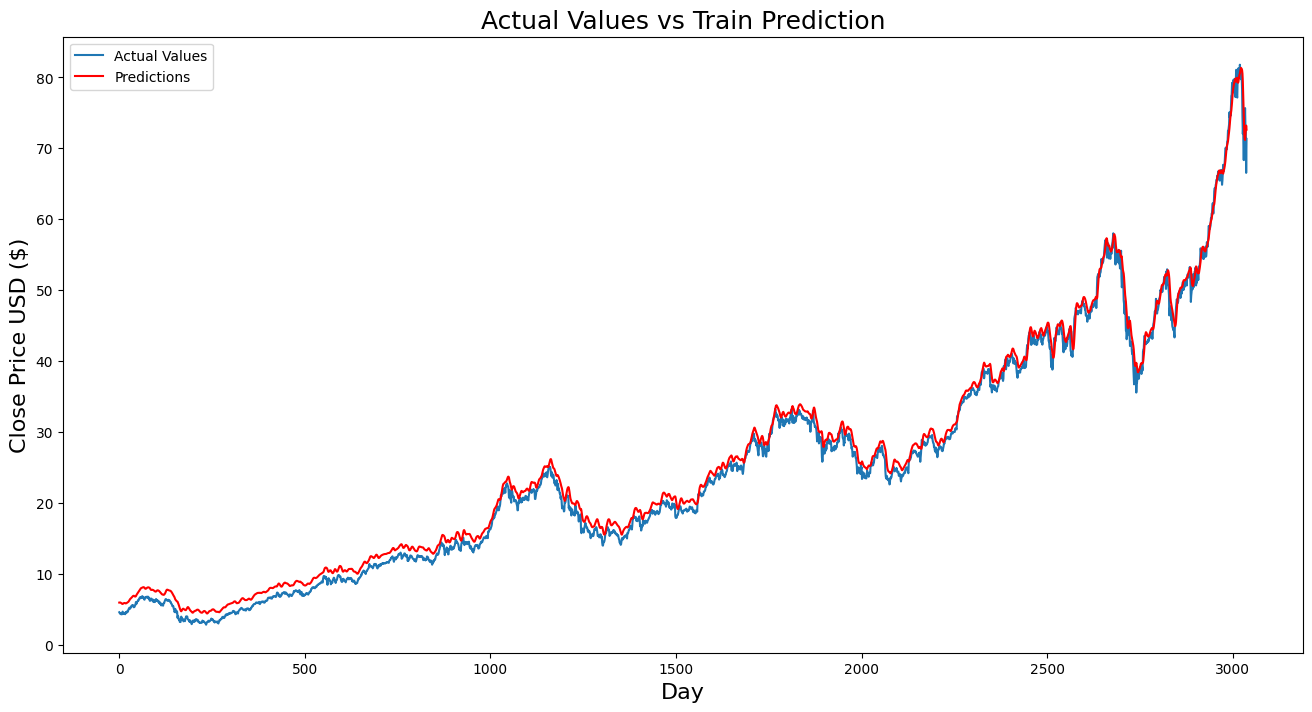

In [24]:
plt.figure(figsize=(16,8))
plt.title('Actual Values vs Train Prediction', fontsize=18)
plt.xlabel('Day', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.plot(scaler.inverse_transform(scaled_data[30:3068]))
plt.plot(train_predict, color='red')
plt.legend(['Actual Values', 'Predictions'], loc='upper left')
plt.show()

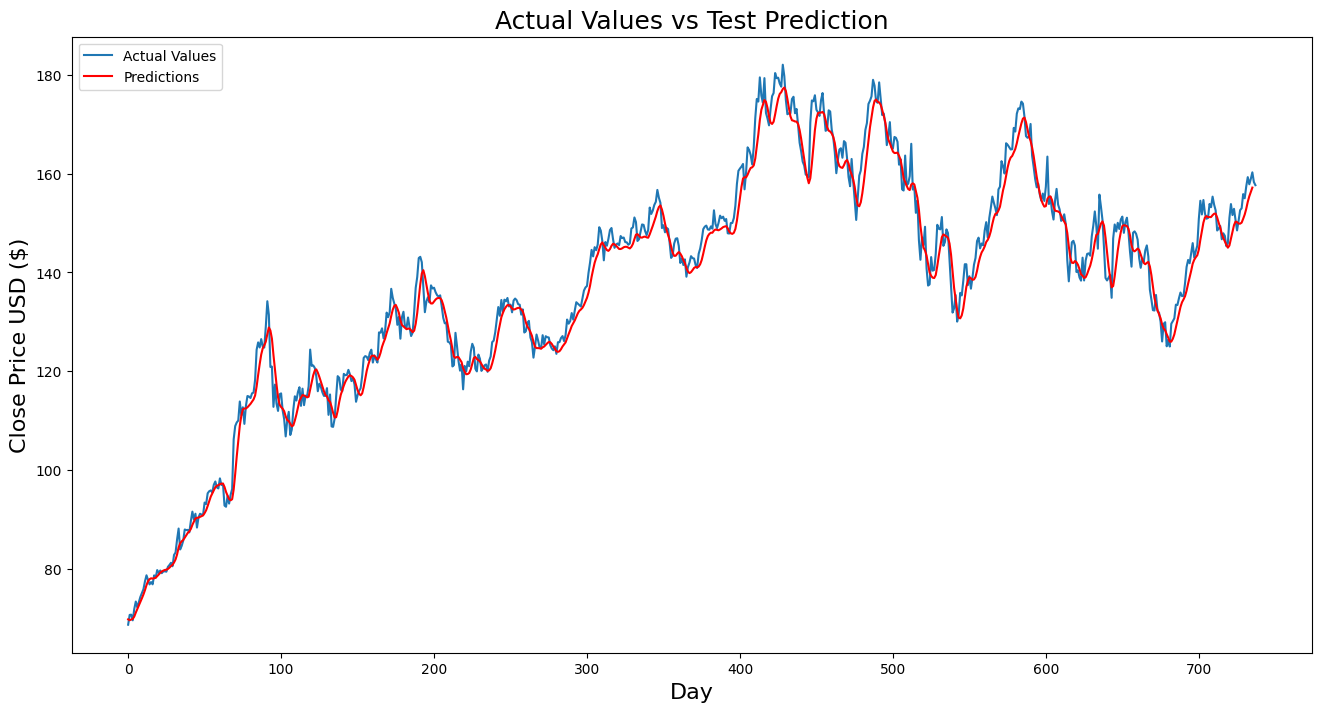

In [25]:
#Plot the test data and prediction
plt.figure(figsize=(16,8))
plt.title('Actual Values vs Test Prediction', fontsize=18)
plt.xlabel('Day', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
#Plot only the test data
plt.plot(scaler.inverse_transform(scaled_data[3098:]))
plt.plot(test_predict, color='red')
plt.legend(['Actual Values', 'Predictions'], loc='upper left')
plt.show()

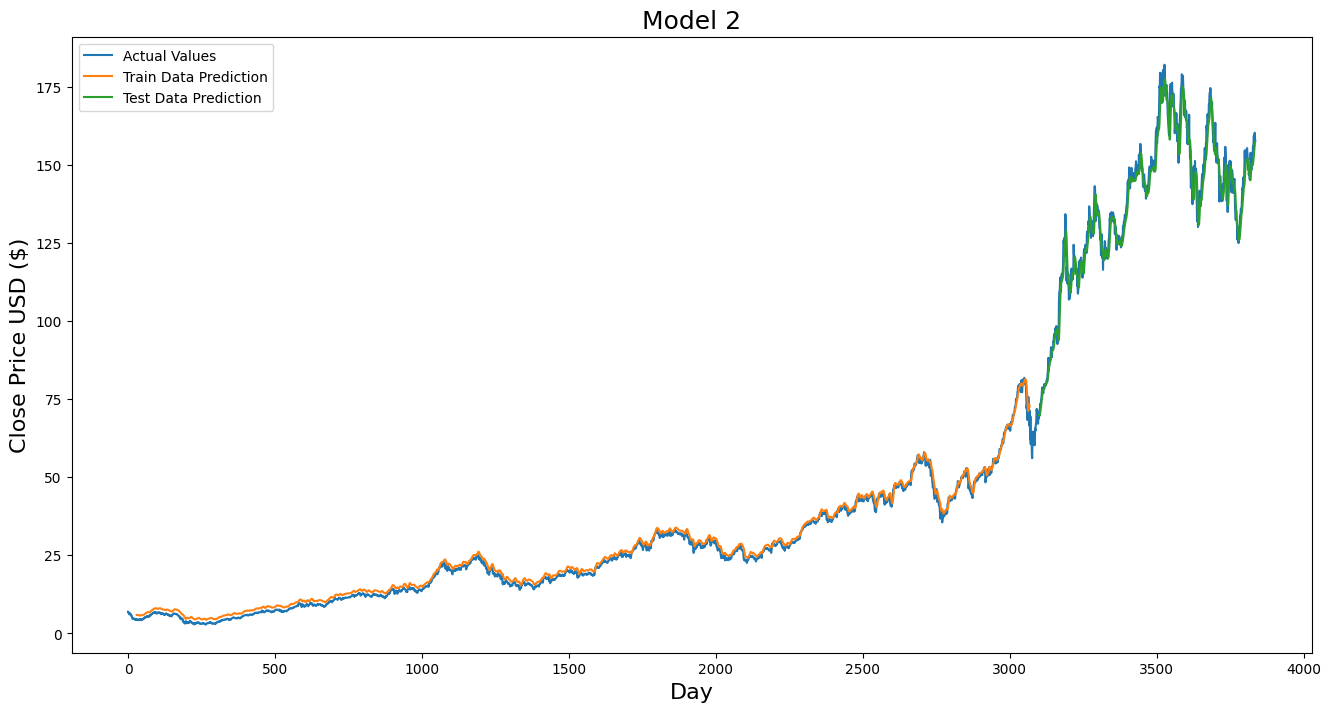

In [50]:
#Plot the data
look_back = 30
trainPredictPlot = np.empty_like(scaled_data)

trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

#Plot the testing data and the model predictions
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict

#Plot the data
plt.figure(figsize=(16,8))
plt.title('Model 2', fontsize=18)
plt.xlabel('Day', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
#plt.plot(y_test)
plt.plot(testPredictPlot)
plt.legend(['Actual Values', 'Train Data Prediction', 'Test Data Prediction'], loc='upper left')
plt.show()

In [27]:
print(len(train_data))
print(len(test_data))

3069
767


In [28]:
#Get the last 30 days of the training data and convert it to an array (765 - 30 = 685)
x_input = test_data[737:].reshape(1,-1) #Predict the closing price for the next 30 days starting from 685
x_input.shape

(1, 30)

In [29]:
#Convert the data to a list
temp_input = list(x_input)
temp_input = temp_input[0].tolist() #Convert the data to a list

print(len(temp_input)) #The length of the list should be 30 as we are predicting the closing price for the next 30 days

30


In [30]:
#Predict the closing price for the next 30 days
#Code taken from tutorial video on how to predict the next 30 days of stock prices using LSTM

lst_output = []
n_steps = 30
i = 0
while(i<30):
      #if the length of the list is greater than 30, then we will shift by 1 day and take new output as the input for the next day prediction
      if(len(temp_input)>30): #
          #print(temp_input)
          x_input = np.array(temp_input[1:])
          print("{} day input {}".format(i,x_input))
          x_input = x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1))
          #print(x_input)
          yhat = model.predict(x_input, verbose=0)
          print("{} day output {}".format(i,yhat))
          temp_input.extend(yhat[0].tolist())
          temp_input = temp_input[1:]
          #print(temp_input)
          lst_output.extend(yhat.tolist())
          i=i+1
      #If the length of the list is less than 30, then we will add the last 30 days to the list and predict the next 30 days
      else:
          x_input = x_input.reshape((1, n_steps,1)) #Reshape the data to fit the model
          yhat = model.predict(x_input, verbose=0)  #Predict the closing price for the next 30 days
          print(yhat[0]) #Print the predicted closing price
          temp_input.extend(yhat[0].tolist()) #Add the predicted closing price to the list
          print(len(temp_input)) #The length of the list should be 30
          lst_output.extend(yhat.tolist()) #Add the predicted closing price to previous list (temp_input)
          i=i+1 

[0.8627307]
31
1 day input [0.85113035 0.84209106 0.83561845 0.81290852 0.81530789 0.81804195
 0.8030323  0.80978384 0.80693816 0.79522049 0.79856842 0.82713709
 0.84276061 0.83031763 0.83740395 0.82468196 0.81302014 0.8240124
 0.8358416  0.83807358 0.85403188 0.849289   0.86268054 0.87317064
 0.86507991 0.87121766 0.87858307 0.86759081 0.8640755  0.86273068]
1 day output [[0.86058795]]
2 day input [0.84209106 0.83561845 0.81290852 0.81530789 0.81804195 0.8030323
 0.80978384 0.80693816 0.79522049 0.79856842 0.82713709 0.84276061
 0.83031763 0.83740395 0.82468196 0.81302014 0.8240124  0.8358416
 0.83807358 0.85403188 0.849289   0.86268054 0.87317064 0.86507991
 0.87121766 0.87858307 0.86759081 0.8640755  0.86273068 0.86058795]
2 day output [[0.85754186]]
3 day input [0.83561845 0.81290852 0.81530789 0.81804195 0.8030323  0.80978384
 0.80693816 0.79522049 0.79856842 0.82713709 0.84276061 0.83031763
 0.83740395 0.82468196 0.81302014 0.8240124  0.8358416  0.83807358
 0.85403188 0.849289   

In [31]:
day_new = np.arange(1,31) #Create a new array with the previous 30 days
day_pred = np.arange(31,61) #Create a new array with the next 30 days


In [32]:
#Print the predicted closing price for the next 30 days
print(scaler.inverse_transform(lst_output))

[[157.40898024]
 [157.02496677]
 [156.47905428]
 [155.85140179]
 [155.19126481]
 [154.52710066]
 [153.87358663]
 [153.23705725]
 [152.61955283]
 [152.02029356]
 [151.43763439]
 [150.86964184]
 [150.31431836]
 [149.76969841]
 [149.23437195]
 [148.70765532]
 [148.18871532]
 [147.67712465]
 [147.1725308 ]
 [146.67437831]
 [146.18230397]
 [145.69621165]
 [145.21581293]
 [144.74120395]
 [144.27224583]
 [143.80874631]
 [143.35092971]
 [142.89863578]
 [142.45184318]
 [142.01056258]]


In [34]:
#Create an array from date 2023-03-15 to 30 days in future 
future_dates = pd.date_range(start='2023-03-29', end='2023-05-09', freq='B')
#print(future_dates)

#convert it to an array
future_dates = future_dates.to_numpy()
print(future_dates)

future_dates.shape

['2023-03-29T00:00:00.000000000' '2023-03-30T00:00:00.000000000'
 '2023-03-31T00:00:00.000000000' '2023-04-03T00:00:00.000000000'
 '2023-04-04T00:00:00.000000000' '2023-04-05T00:00:00.000000000'
 '2023-04-06T00:00:00.000000000' '2023-04-07T00:00:00.000000000'
 '2023-04-10T00:00:00.000000000' '2023-04-11T00:00:00.000000000'
 '2023-04-12T00:00:00.000000000' '2023-04-13T00:00:00.000000000'
 '2023-04-14T00:00:00.000000000' '2023-04-17T00:00:00.000000000'
 '2023-04-18T00:00:00.000000000' '2023-04-19T00:00:00.000000000'
 '2023-04-20T00:00:00.000000000' '2023-04-21T00:00:00.000000000'
 '2023-04-24T00:00:00.000000000' '2023-04-25T00:00:00.000000000'
 '2023-04-26T00:00:00.000000000' '2023-04-27T00:00:00.000000000'
 '2023-04-28T00:00:00.000000000' '2023-05-01T00:00:00.000000000'
 '2023-05-02T00:00:00.000000000' '2023-05-03T00:00:00.000000000'
 '2023-05-04T00:00:00.000000000' '2023-05-05T00:00:00.000000000'
 '2023-05-08T00:00:00.000000000' '2023-05-09T00:00:00.000000000']


(30,)

In [35]:
#Create empty array of size 30
actual_thirtydays_values = np.empty((30,1))

#Fill the empty array with NaN values
actual_thirtydays_values[:] = np.nan

for i in range(0,30):
  try:
    actual_thirtydays_values[i] = new_data['Close'][i]
  except:
    actual_thirtydays_values[i] = np.nan
    

#Add the date and the actual values to the dataframe
actual_thirtydays_values = pd.DataFrame(actual_thirtydays_values, columns=['Close'])
actual_thirtydays_values['Date'] = future_dates
actual_thirtydays_values = actual_thirtydays_values.set_index('Date')

print (actual_thirtydays_values)

                 Close
Date                  
2023-03-29  160.770004
2023-03-30  162.360001
2023-03-31  164.899994
2023-04-03         NaN
2023-04-04         NaN
2023-04-05         NaN
2023-04-06         NaN
2023-04-07         NaN
2023-04-10         NaN
2023-04-11         NaN
2023-04-12         NaN
2023-04-13         NaN
2023-04-14         NaN
2023-04-17         NaN
2023-04-18         NaN
2023-04-19         NaN
2023-04-20         NaN
2023-04-21         NaN
2023-04-24         NaN
2023-04-25         NaN
2023-04-26         NaN
2023-04-27         NaN
2023-04-28         NaN
2023-05-01         NaN
2023-05-02         NaN
2023-05-03         NaN
2023-05-04         NaN
2023-05-05         NaN
2023-05-08         NaN
2023-05-09         NaN


In [36]:
#add the predicted closing price to the actual closing price
actual_thirtydays_values['Predictions'] = scaler.inverse_transform(lst_output)

print(actual_thirtydays_values)

                 Close  Predictions
Date                               
2023-03-29  160.770004   157.408980
2023-03-30  162.360001   157.024967
2023-03-31  164.899994   156.479054
2023-04-03         NaN   155.851402
2023-04-04         NaN   155.191265
2023-04-05         NaN   154.527101
2023-04-06         NaN   153.873587
2023-04-07         NaN   153.237057
2023-04-10         NaN   152.619553
2023-04-11         NaN   152.020294
2023-04-12         NaN   151.437634
2023-04-13         NaN   150.869642
2023-04-14         NaN   150.314318
2023-04-17         NaN   149.769698
2023-04-18         NaN   149.234372
2023-04-19         NaN   148.707655
2023-04-20         NaN   148.188715
2023-04-21         NaN   147.677125
2023-04-24         NaN   147.172531
2023-04-25         NaN   146.674378
2023-04-26         NaN   146.182304
2023-04-27         NaN   145.696212
2023-04-28         NaN   145.215813
2023-05-01         NaN   144.741204
2023-05-02         NaN   144.272246
2023-05-03         NaN   143

In [37]:
#new column for difference between the prediction prices 
closingPrice = actual_thirtydays_values['Close']
lastDayClosingPrice = closingPrice.iloc[1]
print(lastDayClosingPrice)

162.36000061035156


In [38]:
actual_thirtydays_values['Predictions']

Date
2023-03-29    157.408980
2023-03-30    157.024967
2023-03-31    156.479054
2023-04-03    155.851402
2023-04-04    155.191265
2023-04-05    154.527101
2023-04-06    153.873587
2023-04-07    153.237057
2023-04-10    152.619553
2023-04-11    152.020294
2023-04-12    151.437634
2023-04-13    150.869642
2023-04-14    150.314318
2023-04-17    149.769698
2023-04-18    149.234372
2023-04-19    148.707655
2023-04-20    148.188715
2023-04-21    147.677125
2023-04-24    147.172531
2023-04-25    146.674378
2023-04-26    146.182304
2023-04-27    145.696212
2023-04-28    145.215813
2023-05-01    144.741204
2023-05-02    144.272246
2023-05-03    143.808746
2023-05-04    143.350930
2023-05-05    142.898636
2023-05-08    142.451843
2023-05-09    142.010563
Name: Predictions, dtype: float64

In [39]:
#Calculate the accuracy from the actual closing price and the predicted closing price for the next 30 days

#calculate accuracy by subtracting the actual closing price and the predicted closing price and divide by the actual closing price and multiply by 100 to get the percentage
accuracy = (actual_thirtydays_values['Close'] - actual_thirtydays_values['Predictions']) / actual_thirtydays_values['Close'] * 100

#add the accuracy to the actual closing price and the predicted closing price
actual_thirtydays_values['Accuracy'] = (accuracy)

print (actual_thirtydays_values)

                 Close  Predictions  Accuracy
Date                                         
2023-03-29  160.770004   157.408980  2.090579
2023-03-30  162.360001   157.024967  3.285929
2023-03-31  164.899994   156.479054  5.106695
2023-04-03         NaN   155.851402       NaN
2023-04-04         NaN   155.191265       NaN
2023-04-05         NaN   154.527101       NaN
2023-04-06         NaN   153.873587       NaN
2023-04-07         NaN   153.237057       NaN
2023-04-10         NaN   152.619553       NaN
2023-04-11         NaN   152.020294       NaN
2023-04-12         NaN   151.437634       NaN
2023-04-13         NaN   150.869642       NaN
2023-04-14         NaN   150.314318       NaN
2023-04-17         NaN   149.769698       NaN
2023-04-18         NaN   149.234372       NaN
2023-04-19         NaN   148.707655       NaN
2023-04-20         NaN   148.188715       NaN
2023-04-21         NaN   147.677125       NaN
2023-04-24         NaN   147.172531       NaN
2023-04-25         NaN   146.67437

In [40]:
closingPrice = actual_thirtydays_values['Close']
print(closingPrice)

Date
2023-03-29    160.770004
2023-03-30    162.360001
2023-03-31    164.899994
2023-04-03           NaN
2023-04-04           NaN
2023-04-05           NaN
2023-04-06           NaN
2023-04-07           NaN
2023-04-10           NaN
2023-04-11           NaN
2023-04-12           NaN
2023-04-13           NaN
2023-04-14           NaN
2023-04-17           NaN
2023-04-18           NaN
2023-04-19           NaN
2023-04-20           NaN
2023-04-21           NaN
2023-04-24           NaN
2023-04-25           NaN
2023-04-26           NaN
2023-04-27           NaN
2023-04-28           NaN
2023-05-01           NaN
2023-05-02           NaN
2023-05-03           NaN
2023-05-04           NaN
2023-05-05           NaN
2023-05-08           NaN
2023-05-09           NaN
Name: Close, dtype: float64


In [41]:
lastDayClosingPrice = closingPrice.iloc[0]
print(lastDayClosingPrice)
firstPredicted = actual_thirtydays_values['Predictions'].iloc[0]
print(firstPredicted)
loss_percentage = (lastDayClosingPrice - firstPredicted) / lastDayClosingPrice * 100
print(loss_percentage)


160.77000427246094
157.40898023938198
2.090579053156552


In [42]:
#Add new column Buy/Sell/Hold to the dataframe with nil values
actual_thirtydays_values['Buy/Sell/Hold'] = 'NIL'
actual_thirtydays_values['Profit/Loss'] = 0.0
print(actual_thirtydays_values)

                 Close  Predictions  Accuracy Buy/Sell/Hold  Profit/Loss
Date                                                                    
2023-03-29  160.770004   157.408980  2.090579           NIL          0.0
2023-03-30  162.360001   157.024967  3.285929           NIL          0.0
2023-03-31  164.899994   156.479054  5.106695           NIL          0.0
2023-04-03         NaN   155.851402       NaN           NIL          0.0
2023-04-04         NaN   155.191265       NaN           NIL          0.0
2023-04-05         NaN   154.527101       NaN           NIL          0.0
2023-04-06         NaN   153.873587       NaN           NIL          0.0
2023-04-07         NaN   153.237057       NaN           NIL          0.0
2023-04-10         NaN   152.619553       NaN           NIL          0.0
2023-04-11         NaN   152.020294       NaN           NIL          0.0
2023-04-12         NaN   151.437634       NaN           NIL          0.0
2023-04-13         NaN   150.869642       NaN      

In [43]:
lastDay = data['Close'].iloc[-1]
print(lastDay)
firstPredicted = actual_thirtydays_values['Predictions'].iloc[0]
print(firstPredicted)
difference = firstPredicted - lastDay
print(difference)

157.64999389648438
157.40898023938198
-0.24101365710239975


In [44]:
print(actual_thirtydays_values.head(10))

                 Close  Predictions  Accuracy Buy/Sell/Hold  Profit/Loss
Date                                                                    
2023-03-29  160.770004   157.408980  2.090579           NIL          0.0
2023-03-30  162.360001   157.024967  3.285929           NIL          0.0
2023-03-31  164.899994   156.479054  5.106695           NIL          0.0
2023-04-03         NaN   155.851402       NaN           NIL          0.0
2023-04-04         NaN   155.191265       NaN           NIL          0.0
2023-04-05         NaN   154.527101       NaN           NIL          0.0
2023-04-06         NaN   153.873587       NaN           NIL          0.0
2023-04-07         NaN   153.237057       NaN           NIL          0.0
2023-04-10         NaN   152.619553       NaN           NIL          0.0
2023-04-11         NaN   152.020294       NaN           NIL          0.0


In [45]:
#ADD PROFIT COLUMN TO THE DATAFRAME
actual_thirtydays_values['Profit/Loss'] = np.nan
print(actual_thirtydays_values.head(10))

                 Close  Predictions  Accuracy Buy/Sell/Hold  Profit/Loss
Date                                                                    
2023-03-29  160.770004   157.408980  2.090579           NIL          NaN
2023-03-30  162.360001   157.024967  3.285929           NIL          NaN
2023-03-31  164.899994   156.479054  5.106695           NIL          NaN
2023-04-03         NaN   155.851402       NaN           NIL          NaN
2023-04-04         NaN   155.191265       NaN           NIL          NaN
2023-04-05         NaN   154.527101       NaN           NIL          NaN
2023-04-06         NaN   153.873587       NaN           NIL          NaN
2023-04-07         NaN   153.237057       NaN           NIL          NaN
2023-04-10         NaN   152.619553       NaN           NIL          NaN
2023-04-11         NaN   152.020294       NaN           NIL          NaN


In [46]:
total_difference  = difference
total_percentage = difference / lastDay * 100
print(total_difference)
print(total_percentage)

-0.24101365710239975
-0.1528789511153761


In [47]:
for i in range(0,29):
  if (i == 0):
    actual_thirtydays_values['Profit/Loss'][i] = total_difference
  else :
    total_difference  = total_difference + (actual_thirtydays_values['Predictions'][i] - actual_thirtydays_values['Predictions'][i-1])
    #print(total_difference)
    actual_thirtydays_values['Profit/Loss'][i] = total_difference

print(actual_thirtydays_values.head(10))

                 Close  Predictions  Accuracy Buy/Sell/Hold  Profit/Loss
Date                                                                    
2023-03-29  160.770004   157.408980  2.090579           NIL    -0.241014
2023-03-30  162.360001   157.024967  3.285929           NIL    -0.625027
2023-03-31  164.899994   156.479054  5.106695           NIL    -1.170940
2023-04-03         NaN   155.851402       NaN           NIL    -1.798592
2023-04-04         NaN   155.191265       NaN           NIL    -2.458729
2023-04-05         NaN   154.527101       NaN           NIL    -3.122893
2023-04-06         NaN   153.873587       NaN           NIL    -3.776407
2023-04-07         NaN   153.237057       NaN           NIL    -4.412937
2023-04-10         NaN   152.619553       NaN           NIL    -5.030441
2023-04-11         NaN   152.020294       NaN           NIL    -5.629700


<ipython-input-47-ec24cba3352e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_thirtydays_values['Profit/Loss'][i] = total_difference
<ipython-input-47-ec24cba3352e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_thirtydays_values['Profit/Loss'][i] = total_difference


In [48]:
#ADD PROFIT COLUMN TO THE DATAFRAME
actual_thirtydays_values['Profit %'] = 0.0
print(actual_thirtydays_values.head(10))

                 Close  Predictions  Accuracy Buy/Sell/Hold  Profit/Loss  \
Date                                                                       
2023-03-29  160.770004   157.408980  2.090579           NIL    -0.241014   
2023-03-30  162.360001   157.024967  3.285929           NIL    -0.625027   
2023-03-31  164.899994   156.479054  5.106695           NIL    -1.170940   
2023-04-03         NaN   155.851402       NaN           NIL    -1.798592   
2023-04-04         NaN   155.191265       NaN           NIL    -2.458729   
2023-04-05         NaN   154.527101       NaN           NIL    -3.122893   
2023-04-06         NaN   153.873587       NaN           NIL    -3.776407   
2023-04-07         NaN   153.237057       NaN           NIL    -4.412937   
2023-04-10         NaN   152.619553       NaN           NIL    -5.030441   
2023-04-11         NaN   152.020294       NaN           NIL    -5.629700   

            Profit %  
Date                  
2023-03-29       0.0  
2023-03-30       0

In [49]:
#print(total_difference)
#print(total_percentage)
i=0
for i in range(0,29):
  if (i == 0):
    actual_thirtydays_values['Profit %'][i] = total_percentage
  else : 
    prediction_loss = (actual_thirtydays_values['Predictions'][i] - actual_thirtydays_values['Predictions'][i-1]) / (actual_thirtydays_values['Predictions'][i-1]) * 100
    #print(prediction_loss)
    total_percentage  = (total_percentage + prediction_loss ) 
    #print(total_percentage)
    actual_thirtydays_values['Profit %'][i] = total_percentage

  #Sell if the profit is less than 4% or the loss is greater than 2%
  if total_percentage > 4 or total_percentage < -2:
      #Calculate loss percentage 
      actual_thirtydays_values['Buy/Sell/Hold'][i] = "Sell"
  #hold if the profit is between -4% and 4%
  elif total_percentage >= -2 or total_percentage <= 4:
      actual_thirtydays_values['Buy/Sell/Hold'][i] = 'Hold'
  #Buy if the profit is greater than -4%
  elif total_percentage < -5:
      actual_thirtydays_values['Buy/Sell/Hold'][i] = 'Buy'

print(actual_thirtydays_values.head(10))

                 Close  Predictions  Accuracy Buy/Sell/Hold  Profit/Loss  \
Date                                                                       
2023-03-29  160.770004   157.408980  2.090579          Hold    -0.241014   
2023-03-30  162.360001   157.024967  3.285929          Hold    -0.625027   
2023-03-31  164.899994   156.479054  5.106695          Hold    -1.170940   
2023-04-03         NaN   155.851402       NaN          Hold    -1.798592   
2023-04-04         NaN   155.191265       NaN          Hold    -2.458729   
2023-04-05         NaN   154.527101       NaN          Hold    -3.122893   
2023-04-06         NaN   153.873587       NaN          Sell    -3.776407   
2023-04-07         NaN   153.237057       NaN          Sell    -4.412937   
2023-04-10         NaN   152.619553       NaN          Sell    -5.030441   
2023-04-11         NaN   152.020294       NaN          Sell    -5.629700   

            Profit %  
Date                  
2023-03-29 -0.152879  
2023-03-30 -0.3968

<ipython-input-49-53b8ba31e85b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_thirtydays_values['Profit %'][i] = total_percentage
<ipython-input-49-53b8ba31e85b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_thirtydays_values['Buy/Sell/Hold'][i] = 'Hold'
<ipython-input-49-53b8ba31e85b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_thirtydays_values['Profit %'][i] = total_percentage
<ipython-input-49-53b8